# پیش‌بینی قیمت اجاره در داده‌های دیوار

**هدف نوت‌بوک:** ساخت مدلی برای پیش‌بینی قیمت اجاره مسکن و تجاری با استفاده از داده‌های دیوار.

In [35]:
# وارد کردن کتابخانه‌های ضروری
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer # برای پر کردن مقادیر گمشده با KNN

## ۱. بارگذاری و کاوش اولیه داده‌ها

در این بخش، داده‌ها از فایل CSV بارگذاری شده و یک بررسی اولیه شامل شکل داده‌ها، ستون‌ها، انواع داده، مقادیر گمشده و آمارهای توصیفی انجام می‌شود.

In [36]:
# بارگذاری داده‌ها
rent_data = pd.read_csv("Divar.csv", index_col=0, low_memory=False)

# نمایش اطلاعات اولیه
print("تعداد ردیف‌ها و ستون‌ها:", rent_data.shape)
print("ستون‌ها:", rent_data.columns.tolist())
print("تعداد مقادیر گمشده در ستون rent_value:", rent_data["rent_value"].isna().sum())

تعداد ردیف‌ها و ستون‌ها: (1000000, 60)
ستون‌ها: ['cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug', 'created_at_month', 'user_type', 'description', 'title', 'rent_mode', 'rent_value', 'rent_to_single', 'rent_type', 'price_mode', 'price_value', 'credit_mode', 'credit_value', 'rent_credit_transform', 'transformable_price', 'transformable_credit', 'transformed_credit', 'transformable_rent', 'transformed_rent', 'land_size', 'building_size', 'deed_type', 'has_business_deed', 'floor', 'rooms_count', 'total_floors_count', 'unit_per_floor', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_water', 'has_warm_water_provider', 'has_electricity', 'has_gas', 'has_heating_system', 'has_cooling_system', 'has_restroom', 'has_security_guard', 'has_barbecue', 'building_direction', 'has_pool', 'has_jacuzzi', 'has_sauna', 'floor_material', 'property_type', 'regular_person_capacity', 'extra_person_capacity', 'cost_per_extra_person', 'rent_price_

In [37]:
rent_data.describe(include='all')

,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,rent_value,...,property_type,regular_person_capacity,extra_person_capacity,cost_per_extra_person,rent_price_on_regular_days,rent_price_on_special_days,rent_price_at_weekends,location_latitude,location_longitude,location_radius
count,1000000,999999,999998,437139,1000000,288882,1000000,999946,352994,3.513220e+05,...,27057,29870.000000,24009,1.024100e+04,1.806800e+04,1.046300e+04,1.355100e+04,655608.000000,655608.000000,339699.000000
unique,6,16,421,1188,46,2,989449,904092,3,NaN,...,5,NaN,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,residential-sell,apartment-sell,tehran,elahiyehblvd,2024-07-01 00:00:00,مشاور املاک,❌فروش ویلا و زمین زیرقیمت منطقه و بدون واسطه ب...,خانه ویلایی,مقطوع,NaN,...,jungle,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,558708,303385,190904,7076,133219,256006,220,1867,292081,NaN,...,16614,NaN,6849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.102299e+10,...,NaN,6.557650,NaN,1.209785e+10,1.389016e+11,2.355548e+10,3.156551e+10,34.982108,51.629743,465.149147
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807534e+12,...,NaN,7.698655,NaN,1.103482e+12,7.042335e+12,1.542049e+12,2.434942e+12,2.379169,3.160920,125.896250
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,...,NaN,1.000000,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,23.626478,40.162369,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.111110e+05,...,NaN,3.000000,NaN,5.000000e+04,4.000000e+05,6.000000e+05,5.500000e+05,34.553551,50.677175,500.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+06,...,NaN,4.000000,NaN,1.000000e+05,8.000000e+05,1.200000e+06,1.100000e+06,35.723312,51.345791,500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200000e+07,...,NaN,7.000000,NaN,2.000000e+05,1.600000e+06,2.500000e+06,2.500000e+06,36.307013,51.805291,500.000000


In [38]:
# نمایش 5 ردیف اول داده‌ها
rent_data.head()

,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,rent_value,...,property_type,regular_person_capacity,extra_person_capacity,cost_per_extra_person,rent_price_on_regular_days,rent_price_on_special_days,rent_price_at_weekends,location_latitude,location_longitude,location_radius
0,temporary-rent,villa,karaj,mehrshahr,2024-08-01 00:00:00,مشاور املاک,۵۰۰متر\n۲۰۰متر بنا دوبلکس\n۳خواب\nاستخر آبگرم ...,باغ ویلا اجاره روزانه استخر داخل لشکرآباد سهیلیه,NaN,NaN,...,NaN,4.0,6,350000.0,1500000.0,3.500000e+09,3500000.0,35.811684,50.936600,500.0
1,residential-sell,apartment-sell,tehran,gholhak,2024-05-01 00:00:00,مشاور املاک,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,۶۰ متر قلهک فول امکانات,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
2,residential-rent,apartment-rent,tehran,tohid,2024-10-01 00:00:00,NaN,تخلیه پایان ماه,آپارتمان ۳ خوابه ۱۳۲ متر,مقطوع,26000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.703865,51.373459,NaN
3,commercial-rent,office-rent,tehran,elahiyeh,2024-06-01 00:00:00,NaN,فرشته تاپ لوکیشن\n۹۰ متر موقعیت اداری\nیک اتاق...,فرشته ۹۰ متر دفتر کار مدرن موقعیت اداری,مقطوع,95000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,residential-sell,apartment-sell,mashhad,emamreza,2024-05-01 00:00:00,مشاور املاک,هلدینگ ساختمانی اکبری\n\nهمراه شما هستیم برای ...,۱۱۵ متری/شمالی رو به آفتاب/اکبری,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
rent_data['cat2_slug'].value_counts()

cat2_slug
residential-sell        558708
residential-rent        276558
commercial-rent          76567
commercial-sell          38861
temporary-rent           29903
real-estate-services     19403
Name: count, dtype: int64

In [40]:
rent_data['cat3_slug'].value_counts()

cat3_slug
apartment-sell                        303385
apartment-rent                        211880
plot-old                              133570
house-villa-sell                      121753
house-villa-rent                       64678
shop-rent                              45993
shop-sell                              21855
office-rent                            21418
suite-apartment                        16465
presell                                15781
villa                                  12899
industry-agriculture-business-sell     11851
industry-agriculture-business-rent      9155
office-sell                             5155
partnership                             3622
workspace                                539
Name: count, dtype: int64

In [41]:
rent_data['city_slug'].value_counts()

city_slug
tehran           190904
mashhad           69032
karaj             49367
shiraz            37141
isfahan           36953
                  ...  
goli-dagh             5
maraveh-tapeh         5
khoour                3
yanghagh              2
tatar-olya            1
Name: count, Length: 421, dtype: int64

In [42]:
# نمایش مقادیر یکتا و تعداد آن‌ها برای ستون‌های مهم امکانات
print("مقادیر یکتا در ستون 'has_warm_water_provider':")
print(rent_data["has_warm_water_provider"].value_counts(dropna=False))
print("\n" + "=" * 30 + "\n")

print("مقادیر یکتا در ستون 'has_heating_system':")
print(rent_data["has_heating_system"].value_counts(dropna=False))
print("\n" + "=" * 30 + "\n")

print("مقادیر یکتا در ستون 'has_cooling_system':")
print(rent_data["has_cooling_system"].value_counts(dropna=False))
print("\n" + "=" * 30 + "\n")

print("مقادیر یکتا در ستون 'floor_material':")
print(rent_data["floor_material"].value_counts(dropna=False))
print("\n" + "=" * 30 + "\n")

print("مقادیر یکتا در ستون 'building_direction':")
print(rent_data["building_direction"].value_counts(dropna=False))

مقادیر یکتا در ستون 'has_warm_water_provider':
has_warm_water_provider
NaN             620500
package         205641
water_heater    141082
powerhouse       31395
unselect          1382
Name: count, dtype: int64


مقادیر یکتا در ستون 'has_heating_system':
has_heating_system
NaN              631031
shoofaj          201356
heater           119771
duct_split        22047
floor_heating      7717
split              5845
fan_coil           5065
fireplace          4050
unselect           3118
Name: count, dtype: int64


مقادیر یکتا در ستون 'has_cooling_system':
has_cooling_system
NaN                649381
water_cooler       219266
air_conditioner     52341
split               38708
duct_split          29373
unselect             5917
fan_coil             5014
Name: count, dtype: int64


مقادیر یکتا در ستون 'floor_material':
floor_material
NaN                 594016
ceramic             307821
stone                38395
carpet               17696
mosaic               14611
wood_parquet         1

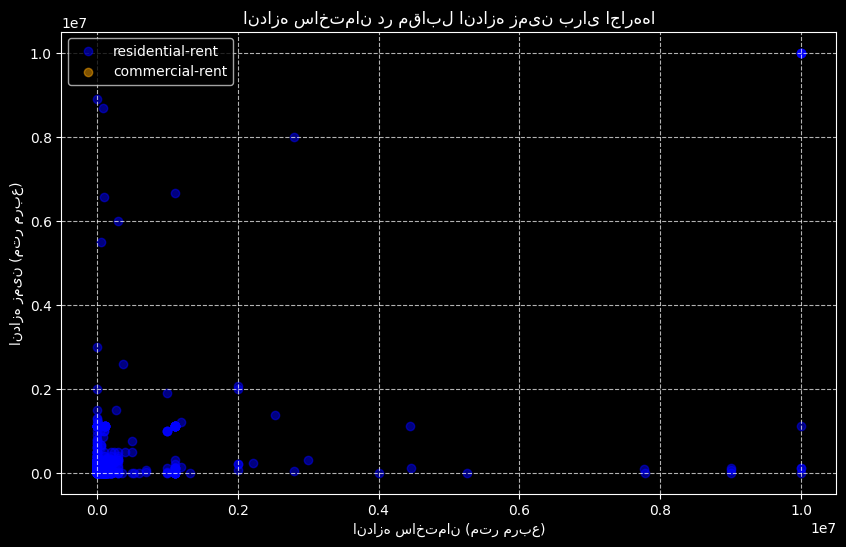

In [43]:
# رسم پراکنش برای داده‌های فیلتر شده
df_rent_eda = rent_data[rent_data["cat2_slug"].isin(["residential-rent", "commercial-rent"])].dropna(
    subset=["rent_value"]
)
plt.figure(figsize=(10, 6))
for category, color in zip(["residential-rent", "commercial-rent"], ["blue", "orange"]):
    subset = df_rent_eda[df_rent_eda["cat2_slug"] == category]
    plt.scatter(
        subset["building_size"], subset["land_size"], alpha=0.5, c=color, label=category
    )
plt.xlabel("اندازه ساختمان (متر مربع)")
plt.ylabel("اندازه زمین (متر مربع)")
plt.title("اندازه ساختمان در مقابل اندازه زمین برای اجاره‌ها")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

## ۲. پیش‌پردازش اولیه داده‌ها

### ۲.۱. بررسی و اصلاح ستون‌های با انواع داده مختلط (Mixed Types)
اخطار `DtypeWarning` هنگام بارگذاری داده‌ها نشان می‌دهد که برخی ستون‌ها دارای انواع داده مختلط هستند. در این بخش این ستون‌ها بررسی و در صورت نیاز اصلاح می‌شوند.

In [44]:
# انتخاب ستون‌ها با ایندکس‌های مشخص
mixed_type_columns_indices = [10, 26, 28, 52] # ایندکس ستون‌های rent_to_single, floor, total_floors_count, extra_person_capacity
selected_columns = rent_data.columns[mixed_type_columns_indices]
# گرفتن مقادیر یکتا برای هر ستون
for col in selected_columns:
    print(f"مقادیر یکتا در ستون '{col}': {rent_data[col].unique()}")

مقادیر یکتا در ستون 'rent_to_single': [nan True False]
مقادیر یکتا در ستون 'floor': [nan '3' '4' '2' '1' '5' '0' '30' '6' '7' '8' '18' '12' '11' '10' '-1'
 '13' '9' '19' '16' '30+' '21' '15' '22' '14' '17' '20' '23' '25' '24'
 '26' '28' '29' '27' '3.0' '2.0' '4.0' '1.0' '0.0' '20.0' '5.0' '7.0'
 '6.0' '18.0' '8.0' '-1.0' '22.0' '10.0' '14.0' '9.0' '11.0']
مقادیر یکتا در ستون 'total_floors_count': [nan '6' '3' '14' '5' '4' '2' '7' '8' '10' '11' '12' '17' '9' '25' '18'
 '19' '15' '16' '21' '20' '22' '13' '24' '30+' '29' '26' '30' 'unselect'
 '27' '23' '28' '4.0' '5.0' '6.0' '2.0' '3.0' '14.0' '25.0' '8.0' '7.0'
 '20.0' '11.0' '10.0' '12.0' '13.0' '21.0' '19.0']
مقادیر یکتا در ستون 'extra_person_capacity': ['6' nan '7' '2' '1' '0' '4' '3' '10' '8' '15' '25' '5' '30+' '29' '11'
 '12' '20' '14' '28' '18' '13' '9' '19' '17' '24' '27' '21' '23' '16' '26'
 '22' '4.0' '5.0' '1.0' '2.0' '6.0']


In [45]:
# پاکسازی داده‌ها برای ستون‌های عددی مرتبط
rent_data["floor"] = rent_data["floor"].replace("30+", "31").astype(float) # ابتدا به رشته تبدیل و سپس به عدد
rent_data["total_floors_count"] = (
    rent_data["total_floors_count"].replace({"30+": "31", "unselect": np.nan}).astype(float)
)
rent_data["extra_person_capacity"] = rent_data["extra_person_capacity"].replace({"30+": "31", "unselect": np.nan}).astype(float) # اضافه شد

### ۲.۲. فیلتر کردن داده‌ها برای آگهی‌های اجاره
در این مرحله، داده‌ها را فقط به آگهی‌های مربوط به اجاره مسکونی و تجاری محدود می‌کنیم.

In [46]:
# فیلتر کردن داده‌ها فقط برای آگهی‌های اجاره مسکونی و تجاری
rent_categories_to_keep = ["residential-rent", "commercial-rent"]
rent_data_filtered = rent_data[rent_data["cat2_slug"].isin(rent_categories_to_keep)].copy()

# حذف دیتافریم اصلی برای آزاد کردن حافظه
del rent_data

In [47]:
# انتخاب ستون‌های مرتبط با قیمت
price_cols = [
    "rent_value",
    "credit_value",
    "rent_credit_transform", # این ستون نشان می‌دهد آیا تبدیل رهن و اجاره انجام شده است یا خیر
    "transformed_rent",
    "transformed_credit",
]

# نمایش 15 ردیف اول از داده‌های فیلتر شده که ستون rent_credit_transform مقدار دارد (برای بررسی تبدیل رهن و اجاره)
rent_data_filtered[rent_data_filtered["rent_credit_transform"].notna()][price_cols].head(15)

,rent_value,credit_value,rent_credit_transform,transformed_rent,transformed_credit
2,26000000.0,7.500000e+08,False,NaN,NaN
3,95000000.0,9.500000e+08,False,NaN,NaN
5,6000000.0,2.500000e+08,False,1.0,400000000.0
6,16000000.0,1.500000e+08,False,NaN,NaN
11,0.0,1.200000e+09,True,12000000.0,800000000.0
15,18000000.0,1.000000e+08,False,NaN,NaN
17,6000000.0,1.000000e+08,False,NaN,NaN
18,15000000.0,2.500000e+08,False,NaN,NaN
21,100000.0,9.000000e+08,True,21000000.0,200000000.0
23,100000.0,1.000000e+09,False,NaN,NaN


## ۳. پاکسازی داده‌ها و مدیریت مقادیر گمشده

### ۳.۱. مدیریت مقادیر نامناسب و پرت

In [48]:
# بررسی داده‌های پرت در ستون rent_value
Q1 = rent_data_filtered["rent_value"].quantile(0.25)
Q3 = rent_data_filtered["rent_value"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = rent_data_filtered[(rent_data_filtered["rent_value"] < lower_bound) | (rent_data_filtered["rent_value"] > upper_bound)]
print(f"تعداد داده‌های پرت در rent_value: {len(outliers)}")
outliers.head()

تعداد داده‌های پرت در rent_value: 38853


,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,rent_value,...,property_type,regular_person_capacity,extra_person_capacity,cost_per_extra_person,rent_price_on_regular_days,rent_price_on_special_days,rent_price_at_weekends,location_latitude,location_longitude,location_radius
3,commercial-rent,office-rent,tehran,elahiyeh,2024-06-01 00:00:00,NaN,فرشته تاپ لوکیشن\n۹۰ متر موقعیت اداری\nیک اتاق...,فرشته ۹۰ متر دفتر کار مدرن موقعیت اداری,مقطوع,95000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,commercial-rent,industry-agriculture-business-rent,tabriz,NaN,2024-10-01 00:00:00,NaN,سالن ۳۰۰ متری در محدوده پالایشگاه\nامکانات تکم...,سالن کارگاهی۳۰۰ متری,مقطوع,80000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,residential-rent,apartment-rent,tehran,hekmat,2024-10-01 00:00:00,NaN,♻️♦️کل عکسهای واحد موجود میباشد♻️\n\n✅️ مشخصات...,اندرزگو ۱۶۰ متری,مقطوع,60000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.799187,51.445717,500.0
145,residential-rent,apartment-rent,tehran,darrous,2024-07-01 00:00:00,NaN,آپارتمان ۱۵۲ متری در بهترین لوکیشن دروس،خیابان...,۱۵۲ متر ، دروس، یارمحمدی، تک واحدی، سه جهت نور,مقطوع,55000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.776485,51.455589,0.0
154,commercial-rent,office-rent,tehran,mirdamad,2024-05-01 00:00:00,مشاور املاک,نور و نقشه عالی \nدسترسی عالی \nامکانات کامل\n...,۴۰۰ متر/سند اداری/۳ پارکینگ,مقطوع,250000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.757763,51.440048,500.0


In [49]:
# بررسی مقادیر یکتا در ستون price_mode (اگر هنوز وجود دارد)
if 'price_mode' in rent_data_filtered.columns:
    print(rent_data_filtered["price_mode"].value_counts())

price_mode
مقطوع    40
Name: count, dtype: int64


In [50]:
# حذف ردیف‌هایی که price_mode آن‌ها "مجانی" است (اگر این ستون و مقدار وجود دارد)
if 'price_mode' in rent_data_filtered.columns:
    rent_data_filtered = rent_data_filtered[rent_data_filtered["price_mode"] != "مجانی"] 

In [51]:
# بررسی مقادیر یکتا در ستون rent_mode (اگر هنوز وجود دارد)
if 'rent_mode' in rent_data_filtered.columns:
    print(rent_data_filtered['rent_mode'].value_counts())

rent_mode
مقطوع     292071
مجانی      59240
توافقی      1671
Name: count, dtype: int64


In [52]:
# حذف ردیف‌هایی که rent_mode آن‌ها "مجانی" است (اگر این ستون و مقدار وجود دارد)
if 'rent_mode' in rent_data_filtered.columns:
    rent_data_filtered = rent_data_filtered[rent_data_filtered["rent_mode"] != "مجانی"]
    # rent_data_filtered.loc[rent_data_filtered["rent_mode"].isna(), "rent_mode"] = "توافقی" # یا پر کردن با مقدار دیگر

In [53]:
# بررسی مقادیر یکتا در ستون rent_type (اگر هنوز وجود دارد)
if 'rent_type' in rent_data_filtered.columns:
    print(rent_data_filtered['rent_type'].unique())

[nan 'rent_credit']


In [54]:
# اگر نوع اجاره "full_credit" باشد، مقدار اجاره را صفر در نظر می‌گیریم
if 'rent_type' in rent_data_filtered.columns and 'rent_value' in rent_data_filtered.columns:
    rent_data_filtered.loc[rent_data_filtered["rent_type"] == "full_credit",'rent_value']=0
    rent_data_filtered.loc[rent_data_filtered['rent_value']==0,'rent_type'] = "full_credit"

### ۳.۲. تبدیل نوع داده‌ها و یکپارچه‌سازی مقادیر

In [55]:
# تبدیل ستون created_at_month به فرمت سال-ماه
if 'created_at_month' in rent_data_filtered.columns:
    rent_data_filtered["created_at_month"] = pd.to_datetime(rent_data_filtered["created_at_month"])

    # استخراج سال و ماه به فرمت YYYY-MM
    rent_data_filtered["created_at_month"] = rent_data_filtered["created_at_month"].dt.strftime("%Y-%m")

In [56]:
if 'has_restroom' in rent_data_filtered.columns: print("has_restroom:\n", rent_data_filtered["has_restroom"].fillna("unselect").value_counts())
if 'has_cooling_system' in rent_data_filtered.columns: print("\nhas_cooling_system:\n", rent_data_filtered["has_cooling_system"].fillna("unselect").value_counts())
if 'has_warm_water_provider' in rent_data_filtered.columns: print("\nhas_warm_water_provider:\n", rent_data_filtered["has_warm_water_provider"].fillna("unselect").value_counts())
if 'construction_year' in rent_data_filtered.columns:
    print("\nconstruction_year (قبل از تبدیل):\n", rent_data_filtered["construction_year"].value_counts())

has_restroom:
 has_restroom
unselect      167234
squat          66712
squat_seat     57261
seat            2678
Name: count, dtype: int64

has_cooling_system:
 has_cooling_system
unselect           186009
water_cooler        76345
air_conditioner     12794
split                9467
duct_split           7726
fan_coil             1544
Name: count, dtype: int64

has_warm_water_provider:
 has_warm_water_provider
unselect        174487
water_heater     55486
package          52944
powerhouse       10968
Name: count, dtype: int64

construction_year (قبل از تبدیل):
 construction_year
۱۳۹۰           29085
۱۳۹۵           23802
۱۴۰۰           23092
۱۴۰۳           22137
۱۳۹۸           15885
۱۴۰۲           14353
۱۳۸۵           14309
۱۳۹۷           14107
۱۳۹۶           13741
۱۳۹۹           12066
۱۴۰۱           11681
۱۳۸۰           10835
۱۳۹۳           10617
۱۳۹۲           10087
۱۳۸۸            9652
۱۳۹۴            9248
قبل از ۱۳۷۰     7051
۱۳۸۹            6600
۱۳۹۱            6002
۱۳۸۷            5

In [57]:
# تابع تبدیل اعداد و کلمات فارسی به انگلیسی برای ستون‌هایی مانند construction_year و rooms_count
def persian_to_english(text):
    # نگاشت کلمات فارسی به اعداد انگلیسی
    word_mapping = {
        "بدون اتاق": "0",
        "یک": "1",
        "دو": "2",
        "سه": "3",
        "چهار": "4",
        "پنج یا بیشتر": "5",
    }

    # نگاشت اعداد فارسی به انگلیسی
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    english_digits = "0123456789"
    digit_translation_table = str.maketrans(persian_digits, english_digits)

    # تبدیل به رشته
    text = str(text)

    # اگر مقدار در دیکشنری کلمات باشد، مقدار معادل را برگردان
    if text in word_mapping:
        return word_mapping[text]

    # در غیر این صورت، اعداد فارسی را به انگلیسی تبدیل کن
    return text.translate(digit_translation_table)

if 'construction_year' in rent_data_filtered.columns:
    rent_data_filtered.loc[rent_data_filtered["construction_year"] == "قبل از ۱۳۷۰", "construction_year"] = "1369"
    rent_data_filtered["construction_year"] = rent_data_filtered["construction_year"].apply(persian_to_english)
    rent_data_filtered["construction_year"] = pd.to_numeric(rent_data_filtered["construction_year"], errors="coerce")
    print("\nconstruction_year (پس از تبدیل):\n", rent_data_filtered["construction_year"].value_counts(dropna=False))


construction_year (پس از تبدیل):
 construction_year
1390.0    29085
1395.0    23802
1400.0    23092
1403.0    22137
1398.0    15885
1402.0    14353
1385.0    14309
1397.0    14107
1396.0    13741
1399.0    12066
1401.0    11681
1380.0    10835
1393.0    10617
1392.0    10087
1388.0     9652
1394.0     9248
1369.0     7051
1389.0     6600
1391.0     6002
1387.0     5171
1386.0     4632
1383.0     3088
1375.0     2906
1384.0     2597
1382.0     2226
1371.0     2205
1381.0     1082
1378.0     1019
1379.0      846
1377.0      767
1372.0      715
1373.0      653
NaN         595
1376.0      555
1374.0      478
Name: count, dtype: int64


In [58]:
if 'has_heating_system' in rent_data_filtered.columns:
    print(rent_data_filtered["has_heating_system"].fillna("unselect").value_counts())

has_heating_system
unselect         179504
shoofaj           54911
heater            46927
duct_split         6147
floor_heating      1887
split              1586
fan_coil           1559
fireplace          1364
Name: count, dtype: int64


In [59]:
if 'deed_type' in rent_data_filtered.columns: print("deed_type:\n", rent_data_filtered["deed_type"].fillna("unselect").value_counts())
if 'rooms_count' in rent_data_filtered.columns:
    print("\nrooms_count (قبل از تبدیل):\n", rent_data_filtered["rooms_count"].value_counts(dropna=False))

deed_type:
 deed_type
unselect       293884
single_page         1
Name: count, dtype: int64

rooms_count (قبل از تبدیل):
 rooms_count
دو              124215
یک               77363
بدون اتاق        43312
سه               39168
چهار              5193
پنج یا بیشتر      4135
NaN                499
Name: count, dtype: int64


In [60]:
if 'rooms_count' in rent_data_filtered.columns:
    rent_data_filtered['rooms_count'] = rent_data_filtered["rooms_count"].apply(persian_to_english)
    rent_data_filtered['rooms_count'] = pd.to_numeric(rent_data_filtered['rooms_count'], errors="coerce")
    print("\nrooms_count (پس از تبدیل):\n", rent_data_filtered["rooms_count"].value_counts(dropna=False))
if 'unit_per_floor' in rent_data_filtered.columns: print("\nunit_per_floor (قبل از تبدیل):\n", rent_data_filtered["unit_per_floor"].value_counts(dropna=False))


rooms_count (پس از تبدیل):
 rooms_count
2.0    124215
1.0     77363
0.0     43312
3.0     39168
4.0      5193
5.0      4135
NaN       499
Name: count, dtype: int64

unit_per_floor (قبل از تبدیل):
 unit_per_floor
NaN            204054
1               34780
2               33470
4                9104
3                8149
6                1349
5                1248
8                 905
more_than_8       504
7                 243
unselect           79
Name: count, dtype: int64


In [61]:
if 'unit_per_floor' in rent_data_filtered.columns:
    rent_data_filtered.loc[rent_data_filtered["unit_per_floor"] == "more_than_8", "unit_per_floor"] = "9"
    rent_data_filtered.loc[rent_data_filtered["unit_per_floor"] == "unselect", "unit_per_floor"] = np.nan
    rent_data_filtered["unit_per_floor"] = pd.to_numeric(rent_data_filtered["unit_per_floor"], errors="coerce")
if 'has_balcony' in rent_data_filtered.columns: print("has_balcony (قبل از تبدیل):\n", rent_data_filtered["has_balcony"].value_counts(dropna=False))

has_balcony (قبل از تبدیل):
 has_balcony
NaN         141100
true        109042
false        36067
True          5737
False         1842
unselect        97
Name: count, dtype: int64


In [62]:
if 'has_balcony' in rent_data_filtered.columns:
    rent_data_filtered.loc[rent_data_filtered["has_balcony"] == "unselect", "has_balcony"] = np.nan
    rent_data_filtered["has_balcony"] = rent_data_filtered["has_balcony"].astype(str).str.strip().str.lower()
    rent_data_filtered["has_balcony"] = rent_data_filtered["has_balcony"].map({'true': 1.0, 'false': 0.0, 'nan': np.nan}) # تبدیل به عددی برای KNNImputer
    print("has_balcony (پس از تبدیل به 0 و 1):\n", rent_data_filtered["has_balcony"].value_counts(dropna=False))

has_balcony (پس از تبدیل به 0 و 1):
 has_balcony
NaN    141197
1.0    114779
0.0     37909
Name: count, dtype: int64


In [63]:
# تابع برای تبدیل نوع داده ستون‌ها (در صورت نیاز به تبدیل‌های بیشتر)
def convert_data_types(df_to_convert):
    df = df_to_convert.copy() # برای جلوگیری از SettingWithCopyWarning
    # شناسایی ستون‌های object
    object_cols = df.select_dtypes(include=["object"]).columns

    # تبدیل ستون‌های object قابل تبدیل به عددی
    for col in object_cols:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass  # ستون‌هایی که قابل تبدیل نیستند، نادیده گرفته می‌شوند

    # تبدیل ستون‌های بولین به float برای سازگاری با KNNImputer
    boolean_cols = df.select_dtypes(include=['boolean']).columns
    for col in boolean_cols:
        df[col] = df[col].astype(float)

    # نمایش اطلاعات DataFrame برای بررسی تغییرات
    print(df.dtypes)
    return df

rent_data_filtered = convert_data_types(rent_data_filtered)
rent_data_filtered.head()

cat2_slug                      object
cat3_slug                      object
city_slug                      object
neighborhood_slug              object
created_at_month               object
user_type                      object
description                    object
title                          object
rent_mode                      object
rent_value                    float64
rent_to_single                float64
rent_type                      object
price_mode                     object
price_value                   float64
credit_mode                    object
credit_value                  float64
rent_credit_transform         float64
transformable_price           float64
transformable_credit          float64
transformed_credit            float64
transformable_rent            float64
transformed_rent              float64
land_size                     float64
building_size                 float64
deed_type                      object
has_business_deed             float64
floor       

,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,rent_value,...,property_type,regular_person_capacity,extra_person_capacity,cost_per_extra_person,rent_price_on_regular_days,rent_price_on_special_days,rent_price_at_weekends,location_latitude,location_longitude,location_radius
2,residential-rent,apartment-rent,tehran,tohid,2024-10,NaN,تخلیه پایان ماه,آپارتمان ۳ خوابه ۱۳۲ متر,مقطوع,26000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.703865,51.373459,NaN
3,commercial-rent,office-rent,tehran,elahiyeh,2024-06,NaN,فرشته تاپ لوکیشن\n۹۰ متر موقعیت اداری\nیک اتاق...,فرشته ۹۰ متر دفتر کار مدرن موقعیت اداری,مقطوع,95000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,residential-rent,apartment-rent,ahvaz,mellirah,2024-09,NaN,اپارتمان ۱۰۰متری واحد جلو دارای دو اتاق خواب ک...,اپارتمان ۱۰۰متری ملی راه واحد جلو,مقطوع,6000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,commercial-rent,office-rent,kermanshah,NaN,2024-11,NaN,♦مشاورین املاک سیب♦\n✅️کد:G۱۰۵\n♦با سالها سابق...,واحداداری ۸۰متری ۲۲بهمن(برق),مقطوع,16000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,commercial-rent,office-rent,rasht,moalem,2024-06,مشاور املاک,✅ تجاری \n✅سه اتاقه\n✅ ۸۵متر مفید\n✅ آسانسور\n...,تحاری ۸۵ متر سه اتاقه طبقه ۵ فاز یک معلم,مقطوع,18000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ۳.۳. مدیریت مقادیر گمشده

In [64]:
rent_data_filtered["rent_value"] = rent_data_filtered["rent_value"].fillna(rent_data_filtered["transformed_rent"])
print(f"تعداد مقادیر گمشده در 'rent_value' پس از پر کردن اولیه: {rent_data_filtered['rent_value'].isna().sum()}")

تعداد مقادیر گمشده در 'rent_value' پس از پر کردن اولیه: 1814


In [65]:
# نمایش اطلاعات به‌روز شده DataFrame
rent_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293885 entries, 2 to 999996
Data columns (total 60 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   cat2_slug                   293885 non-null  object 
 1   cat3_slug                   293884 non-null  object 
 2   city_slug                   293884 non-null  object 
 3   neighborhood_slug           146005 non-null  object 
 4   created_at_month            293885 non-null  object 
 5   user_type                   82598 non-null   object 
 6   description                 293885 non-null  object 
 7   title                       293857 non-null  object 
 8   rent_mode                   293742 non-null  object 
 9   rent_value                  292071 non-null  float64
 10  rent_to_single              14 non-null      float64
 11  rent_type                   82165 non-null   object 
 12  price_mode                  40 non-null      object 
 13  price_value        

In [66]:
# حذف ردیف‌هایی که مقادیر گمشده در ستون‌های کلیدی cat3_slug و city_slug دارند (اگر هنوز وجود دارند)
rent_data_filtered.dropna(subset=["cat3_slug","city_slug"], inplace=True)

# محاسبه و نمایش درصد مقادیر گمشده برای هر ستون
na_ratio = rent_data_filtered.isna().mean().sort_values(ascending=False)
print("درصد مقادیر گمشده در هر ستون (پس از حذف ردیف‌های با NaN در ستون‌های کلیدی):")
print(na_ratio)

درصد مقادیر گمشده در هر ستون (پس از حذف ردیف‌های با NaN در ستون‌های کلیدی):
has_business_deed             1.000000
rent_price_on_regular_days    1.000000
extra_person_capacity         1.000000
rent_price_at_weekends        1.000000
rent_price_on_special_days    1.000000
property_type                 1.000000
cost_per_extra_person         1.000000
regular_person_capacity       1.000000
deed_type                     0.999997
rent_to_single                0.999952
price_value                   0.999864
price_mode                    0.999864
has_sauna                     0.985144
has_jacuzzi                   0.985103
has_pool                      0.985082
has_security_guard            0.984987
has_barbecue                  0.984729
has_gas                       0.983960
has_electricity               0.983960
has_water                     0.983960
transformed_rent              0.807325
transformed_credit            0.807325
land_size                     0.805770
rent_type                  

### ۳.۴. حذف ستون‌های با درصد بالای مقادیر گمشده و ستون‌های غیرضروری

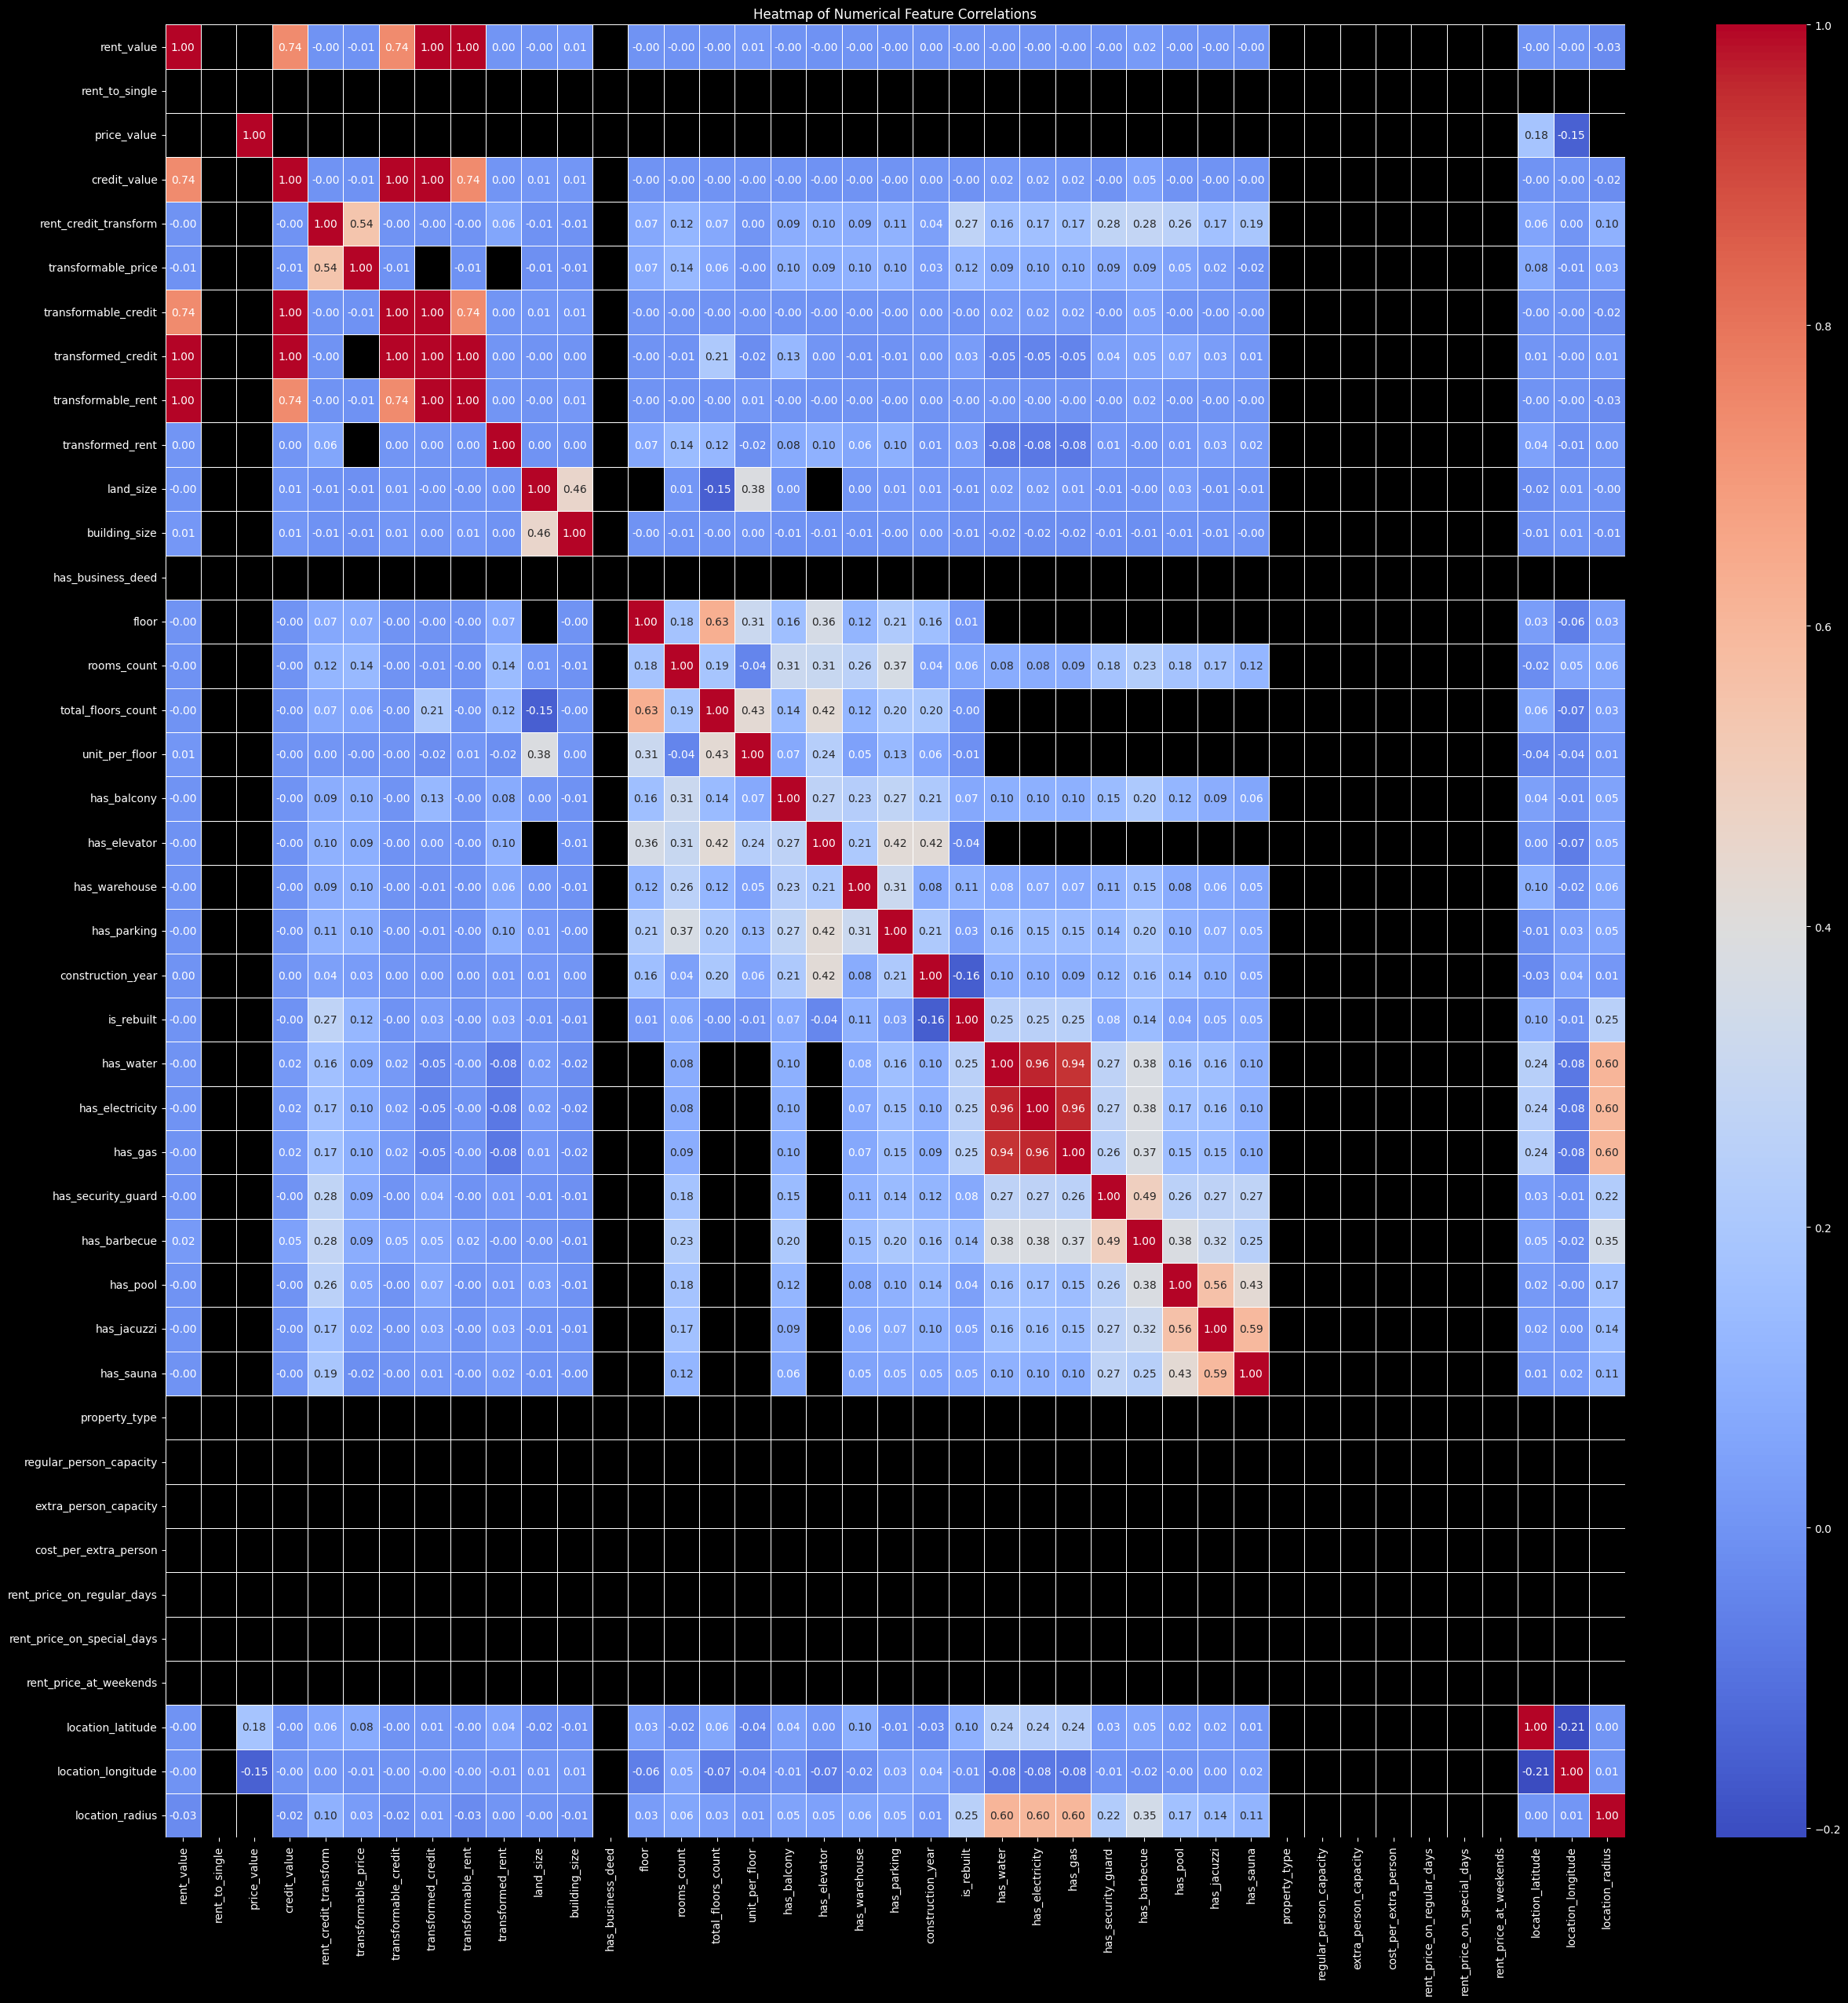

In [67]:
# فیلتر کردن ستون‌های عددی از داده‌های اجاره
numeric_rent_df = rent_data_filtered.select_dtypes(include=["float64", "int64"]).copy() # Use .copy()

# محاسبه ماتریس همبستگی
corr_matrix = numeric_rent_df.corr()

# رسم heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Heatmap of Numerical Feature Correlations")
plt.show()

In [68]:
# شناسایی ستون‌هایی که بیش از 80% مقدار گمشده دارند
threshold_na = 0.80
cols_to_drop_na = na_ratio[na_ratio > threshold_na].index.tolist()
print(f"ستون‌هایی که بیش از {threshold_na*100:.0f}% مقدار گمشده دارند و حذف می‌شوند: {cols_to_drop_na}")
cols_to_drop_na.remove('land_size')
# حذف ستون‌های شناسایی شده
rent_data_filtered = rent_data_filtered.drop(columns=cols_to_drop_na)
print("\nستون‌های باقی‌مانده پس از حذف ستون‌های با NaN زیاد:")
print(rent_data_filtered.columns)

ستون‌هایی که بیش از 80% مقدار گمشده دارند و حذف می‌شوند: ['has_business_deed', 'rent_price_on_regular_days', 'extra_person_capacity', 'rent_price_at_weekends', 'rent_price_on_special_days', 'property_type', 'cost_per_extra_person', 'regular_person_capacity', 'deed_type', 'rent_to_single', 'price_value', 'price_mode', 'has_sauna', 'has_jacuzzi', 'has_pool', 'has_security_guard', 'has_barbecue', 'has_gas', 'has_electricity', 'has_water', 'transformed_rent', 'transformed_credit', 'land_size']

ستون‌های باقی‌مانده پس از حذف ستون‌های با NaN زیاد:
Index(['cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug',
       'created_at_month', 'user_type', 'description', 'title', 'rent_mode',
       'rent_value', 'rent_type', 'credit_mode', 'credit_value',
       'rent_credit_transform', 'transformable_price', 'transformable_credit',
       'transformable_rent', 'land_size', 'building_size', 'floor',
       'rooms_count', 'total_floors_count', 'unit_per_floor', 'has_balcony',
       'has_elevato

In [69]:
# نمایش نهایی انواع داده ستون‌ها
print(rent_data_filtered.dtypes)

cat2_slug                   object
cat3_slug                   object
city_slug                   object
neighborhood_slug           object
created_at_month            object
user_type                   object
description                 object
title                       object
rent_mode                   object
rent_value                 float64
rent_type                   object
credit_mode                 object
credit_value               float64
rent_credit_transform      float64
transformable_price        float64
transformable_credit       float64
transformable_rent         float64
land_size                  float64
building_size              float64
floor                      float64
rooms_count                float64
total_floors_count         float64
unit_per_floor             float64
has_balcony                float64
has_elevator               float64
has_warehouse              float64
has_parking                float64
construction_year          float64
is_rebuilt          

In [70]:
if 'price_mode' in rent_data_filtered.columns:
    print(rent_data_filtered['price_mode'].value_counts(dropna=False))

In [71]:
# اگر price_value مقدار دارد ولی price_mode گمشده است، آن را توافقی در نظر می‌گیریم
if 'price_value' in rent_data_filtered.columns and 'price_mode' in rent_data_filtered.columns:
    rent_data_filtered.loc[rent_data_filtered["price_value"].notnull() & rent_data_filtered["price_mode"].isnull(), "price_mode"] = "توافقی"

In [72]:
if 'credit_mode' in rent_data_filtered.columns:
    print(rent_data_filtered['credit_mode'].value_counts(dropna=False))

credit_mode
مقطوع     289998
مجانی       2863
توافقی       879
NaN          143
Name: count, dtype: int64


In [73]:
if 'credit_mode' in rent_data_filtered.columns:
    rent_data_filtered = rent_data_filtered[rent_data_filtered["credit_mode"] != "مجانی"]
    if 'credit_value' in rent_data_filtered.columns:
        rent_data_filtered.loc[rent_data_filtered["credit_value"].notnull() & rent_data_filtered["credit_mode"].isnull(), "credit_mode"]='توافقی'

In [74]:
if 'deed_type' in rent_data_filtered.columns:
    print(rent_data_filtered["deed_type"].value_counts(dropna=False))

In [75]:
if 'deed_type' in rent_data_filtered.columns:
    rent_data_filtered.loc[rent_data_filtered['deed_type'].isnull(),'deed_type'] = 'unselect'

In [76]:
if 'has_business_deed' in rent_data_filtered.columns:
    print(rent_data_filtered['has_business_deed'].value_counts(dropna=False))

In [77]:
# نمایش 10 ردیف اول داده‌های پاکسازی شده
rent_data_filtered.head(10)

,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,rent_value,...,is_rebuilt,has_warm_water_provider,has_heating_system,has_cooling_system,has_restroom,building_direction,floor_material,location_latitude,location_longitude,location_radius
2,residential-rent,apartment-rent,tehran,tohid,2024-10,NaN,تخلیه پایان ماه,آپارتمان ۳ خوابه ۱۳۲ متر,مقطوع,26000000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,35.703865,51.373459,NaN
3,commercial-rent,office-rent,tehran,elahiyeh,2024-06,NaN,فرشته تاپ لوکیشن\n۹۰ متر موقعیت اداری\nیک اتاق...,فرشته ۹۰ متر دفتر کار مدرن موقعیت اداری,مقطوع,95000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,residential-rent,apartment-rent,ahvaz,mellirah,2024-09,NaN,اپارتمان ۱۰۰متری واحد جلو دارای دو اتاق خواب ک...,اپارتمان ۱۰۰متری ملی راه واحد جلو,مقطوع,6000000.0,...,0.0,water_heater,NaN,NaN,squat,NaN,carpet,NaN,NaN,NaN
6,commercial-rent,office-rent,kermanshah,NaN,2024-11,NaN,♦مشاورین املاک سیب♦\n✅️کد:G۱۰۵\n♦با سالها سابق...,واحداداری ۸۰متری ۲۲بهمن(برق),مقطوع,16000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,commercial-rent,office-rent,rasht,moalem,2024-06,مشاور املاک,✅ تجاری \n✅سه اتاقه\n✅ ۸۵متر مفید\n✅ آسانسور\n...,تحاری ۸۵ متر سه اتاقه طبقه ۵ فاز یک معلم,مقطوع,18000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,residential-rent,apartment-rent,mahabad,NaN,2024-09,شخصی,اجاره یک آپارتمان تعاونی ۱۶ طبقه اول واقع در پ...,اجاره آپارتمان مسکن مهر,مقطوع,6000000.0,...,NaN,package,shoofaj,NaN,squat,NaN,ceramic,NaN,NaN,500.0
18,residential-rent,apartment-rent,shiraz,farhangshahr,2024-08,مشاور املاک,✳️بنام یزدان پاک✳️\n\n️دپارتمان تخصصی املاک ای...,آپارتمان/2خواب/میدان معلم,مقطوع,15000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
21,residential-rent,apartment-rent,andisheh-new-town,NaN,2024-08,مشاور املاک,واحددرمجتمع فوق العاده شیک درفاز۵\nامکانات فول...,آپارتمان۱۲۳متری درفاز۵اندیشه,مقطوع,100000.0,...,NaN,package,shoofaj,water_cooler,squat_seat,NaN,ceramic,35.700031,50.996452,500.0
23,residential-rent,apartment-rent,karaj,gohardasht,2024-08,NaN,"۱۵۵ متر ۳ خواب ۱ خواب مستر\n\nآشپزخانه:مدرن,هو...",۱۵۵ متر نوساز فول امکانات,مقطوع,100000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,residential-rent,house-villa-rent,tehran,shemiran-no,2024-08,NaN,سوییت 48متر یک خوابه سرویس کامل شمالی نورگیر ع...,سوییت 48متر یک خوابه,مقطوع,7000000.0,...,0.0,water_heater,heater,water_cooler,squat,north,carpet,NaN,NaN,NaN


### ۳.۵. پر کردن مقادیر گمشده باقیمانده

In [78]:
if 'building_direction' in rent_data_filtered.columns:
    rent_data_filtered["building_direction"] = rent_data_filtered["building_direction"].fillna("unselect")
    print(rent_data_filtered["building_direction"].value_counts(dropna=False))

building_direction
unselect    198452
south        46266
north        40561
east          3585
west          2156
Name: count, dtype: int64


In [79]:
if 'has_parking' in rent_data_filtered.columns:
    print(rent_data_filtered["has_parking"].value_counts())

has_parking
1.0    156078
0.0     82751
Name: count, dtype: int64


In [80]:
# تبدیل نوع ستون به boolean (nullable)
if 'has_parking' in rent_data_filtered.columns:
    rent_data_filtered["has_parking"] = rent_data_filtered["has_parking"].astype("boolean")

    # شرط برای وجود "پارکینگ" و عدم وجود "ندارد" در description یا title
    condition = rent_data_filtered["has_parking"].isnull() & (
        (
            rent_data_filtered["description"].str.contains("پارکینگ", case=False, na=False)
            & ~rent_data_filtered["description"].str.contains("ندارد", case=False, na=False)
        )
        | (
            rent_data_filtered["title"].str.contains("پارکینگ", case=False, na=False)
            & ~rent_data_filtered["title"].str.contains("ندارد", case=False, na=False)
        )
    )

    # اعمال مقدار True برای شرط بالا
    rent_data_filtered.loc[condition, "has_parking"] = True


    # نمایش آماری
    print(rent_data_filtered["has_parking"].value_counts())

has_parking
True     157293
False     82751
Name: count, dtype: Int64


In [81]:
if 'is_rebuilt' in rent_data_filtered.columns:
    print(rent_data_filtered['is_rebuilt'].value_counts())

is_rebuilt
0.0    115705
1.0     55779
Name: count, dtype: int64


In [82]:
if 'has_warehouse' in rent_data_filtered.columns:
    print(rent_data_filtered['has_warehouse'].value_counts())

has_warehouse
1.0    170802
0.0     68027
Name: count, dtype: int64


In [83]:
if 'has_heating_system' in rent_data_filtered.columns and 'has_warm_water_provider' in rent_data_filtered.columns:
    rent_data_filtered.loc[
        rent_data_filtered["has_heating_system"].isnull()
         & (rent_data_filtered["has_warm_water_provider"] == True), # Assuming True means it has one
        "has_heating_system",
    ] = True


In [84]:
rent_data_filtered.isnull().sum().sort_values(ascending=False)

land_size                  234289
rent_type                  209104
user_type                  208681
total_floors_count         201584
unit_per_floor             201403
location_radius            197310
has_cooling_system         181299
has_heating_system         175743
has_warm_water_provider    171574
floor_material             165188
has_restroom               164487
neighborhood_slug          146502
has_balcony                138840
is_rebuilt                 119536
has_elevator               108929
floor                      108929
location_latitude           99353
location_longitude          99353
has_warehouse               52191
has_parking                 50976
rent_value                   1809
transformable_rent           1809
transformable_credit         1022
credit_value                 1022
construction_year             585
rooms_count                   488
transformable_price           225
rent_mode                     143
credit_mode                   143
rent_credit_tr

In [ ]:
# انتخاب فقط دو ستون مورد نظر برای پر کردن با KNN
columns_to_impute = ["building_size", "land_size"]
df_subset = rent_data_filtered[columns_to_impute].copy()

# ساختن شیء KNN Imputer با 2 همسایه
imputer = KNNImputer(n_neighbors=2)

# پر کردن مقادیر گمشده در دو ستون
# توجه: این عملیات ممکن است زمان‌بر باشد
print("شروع پر کردن مقادیر گمشده با KNN...")
df_imputed = pd.DataFrame(imputer.fit_transform(df_subset), columns=columns_to_impute, index=df_subset.index)
print("پایان پر کردن مقادیر گمشده با KNN.")

# جایگزینی مقادیر پرشده در DataFrame اصلی
rent_data_filtered.loc[:, "building_size"] = df_imputed["building_size"]
rent_data_filtered.loc[:, "land_size"] = df_imputed["land_size"]

# بررسی مقادیر گمشده باقی‌مانده
print("\nتعداد مقادیر گمشده بعد از پر کردن با KNN:")
print(rent_data_filtered[["building_size", "land_size"]].isna().sum())

شروع پر کردن مقادیر گمشده با KNN...


### ۳.۶. حذف نهایی ستون‌های غیرضروری

In [ ]:
if 'location_radius' in rent_data_filtered.columns:
    print(rent_data_filtered["location_radius"].value_counts())

In [ ]:
cols_to_drop_final = [
    "transformable_rent",
    "transformable_price",
    "transformable_credit",
    "description",
    "title",
    "location_radius",
    "user_type", # با توجه به درصد بالای NaN و عدم استفاده مستقیم در مدل فعلی
    "rent_to_single", # اگر هنوز وجود دارد و تماماً NaN است
    "has_water", # اگر هنوز وجود دارد و تماماً NaN است
    "has_gas", # اگر هنوز وجود دارد و تماماً NaN است
    "property_type", # اگر هنوز وجود دارد و تماماً NaN است
    "regular_person_capacity", # اگر هنوز وجود دارد و تماماً NaN است
    "extra_person_capacity", # اگر هنوز وجود دارد و تماماً NaN است
    "cost_per_extra_person", # اگر هنوز وجود دارد و تماماً NaN است
    "rent_price_on_regular_days", # اگر هنوز وجود دارد و تماماً NaN است
    "rent_price_on_special_days", # اگر هنوز وجود دارد و تماماً NaN است
    "rent_price_at_weekends", # اگر هنوز وجود دارد و تماماً NaN است
    "has_security_guard", # اگر هنوز وجود دارد و تماماً NaN است
    "has_barbecue", # اگر هنوز وجود دارد و تماماً NaN است
    "has_pool", # اگر هنوز وجود دارد و تماماً NaN است
    "has_jacuzzi", # اگر هنوز وجود دارد و تماماً NaN است
    "has_sauna" # اگر هنوز وجود دارد و تماماً NaN است
]

# حذف ستون‌هایی که در DataFrame وجود دارند
existing_cols_to_drop = [col for col in cols_to_drop_final if col in rent_data_filtered.columns]
rent_data_filtered = rent_data_filtered.drop(columns=existing_cols_to_drop)

print("ستون‌های باقی‌مانده پس از حذف نهایی:")
print(rent_data_filtered.columns)

In [ ]:
print("انواع داده نهایی قبل از مدل‌سازی:")
print(rent_data_filtered.dtypes)
print("\nنمونه‌ای از داده‌های نهایی:")
rent_data_filtered.head()

In [ ]:
# حذف متغیرهای اضافی برای آزاد کردن حافظه (اگر هنوز وجود دارند)
try:
    del selected_columns, na_ratio, corr_matrix, mixed_type_columns_indices, cols_to_drop_na, threshold_na, price_cols, df_rent_eda, outliers, df_subset, df_imputed, cols_to_drop_final, existing_cols_to_drop
except NameError:
    pass

## ۴. آموزش و ارزیابی مدل پیش‌بینی قیمت اجاره

در این بخش، مدل Random Forest Regressor برای پیش‌بینی `rent_value` آموزش داده و ارزیابی می‌شود.

In [ ]:
# اطمینان از اینکه فقط داده‌های مربوط به اجاره بلندمدت استفاده می‌شوند و rent_value موجود است
df_long_term = rent_data_filtered[
    rent_data_filtered["cat2_slug"].isin(["residential-rent", "commercial-rent"])
    & rent_data_filtered["rent_value"].notna()
].copy()

# استخراج ویژگی‌های زمانی
df_long_term["created_at_month"] = pd.to_datetime(df_long_term["created_at_month"])
df_long_term["year"] = df_long_term["created_at_month"].dt.year
df_long_term["month"] = df_long_term["created_at_month"].dt.month
# محاسبه سن ساختمان
df_long_term['age'] = df_long_term['year'] - df_long_term['construction_year']

# تبدیل has_elevator و has_parking به نوع رشته برای one-hot encoding و پر کردن NaN ها
for col in ["has_elevator", "has_parking"]:
    if col in df_long_term.columns:
        df_long_term[col] = df_long_term[col].fillna('missing').astype(str)

# محدود کردن داده‌های پرت در rent_value
Q1 = df_long_term["rent_value"].quantile(0.05) # استفاده از صدک 5 و 95 برای کاهش تاثیر داده‌های پرت
Q3 = df_long_term["rent_value"].quantile(0.95)
IQR = Q3 - Q1 # این دیگر IQR واقعی نیست، اما برای محدودسازی استفاده می‌شود
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_long_term["rent_value_capped"] = df_long_term["rent_value"].clip(
    lower=lower_bound, upper=upper_bound
)

# انتخاب ویژگی‌ها و متغیر هدف
features = [
    "cat3_slug",
    "city_slug",
    "neighborhood_slug",
    "building_size",
    "land_size",
    "rooms_count",
    "floor",
    "total_floors_count",
    "age",
    "has_elevator", # نام ستون اصلاح شده
    "has_parking",  # نام ستون اصلاح شده
    "year",
    "month",
]
target = "rent_value_capped"

# مدیریت مقادیر گمشده برای ویژگی‌های عددی و دسته‌ای
numeric_features = [
    "building_size",
    "land_size",
    "rooms_count",
    "floor",
    "total_floors_count",
    "age",
    "year",
    "month",
]
categorical_features_model = [
    "cat3_slug",
    "city_slug",
    "neighborhood_slug",
    "has_elevator",
    "has_parking",
]
for col in numeric_features:
    if col in df_long_term.columns:
        df_long_term[col] = df_long_term[col].fillna(df_long_term[col].median())
for col in categorical_features_model:
    if col in df_long_term.columns:
        df_long_term[col] = df_long_term[col].fillna("missing")

# تقسیم داده‌ها
X = df_long_term[features]
y = np.log1p(df_long_term[target]) # تبدیل لگاریتمی برای کاهش اثر داده‌های پرت
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# کدگذاری target encoding برای ستون‌های با کاردینالیتی بالا
for col in ["city_slug", "neighborhood_slug"]:
    if col in X_train.columns:
        means = y_train.groupby(X_train[col]).mean()
        X_train.loc[:, col + "_encoded"] = X_train[col].map(means)
        X_test.loc[:, col + "_encoded"] = X_test[col].map(means).fillna(y_train.mean())
        X_train = X_train.drop(columns=[col])
        X_test = X_test.drop(columns=[col])

# کدگذاری one-hot برای ستون‌های دسته‌ای باقیمانده
categorical_to_encode = ["cat3_slug", "has_elevator", "has_parking"]
X_train = pd.get_dummies(
    X_train, columns=[col for col in categorical_to_encode if col in X_train.columns], prefix=[col for col in categorical_to_encode if col in X_train.columns]
)
X_test = pd.get_dummies(
    X_test, columns=[col for col in categorical_to_encode if col in X_test.columns], prefix=[col for col in categorical_to_encode if col in X_test.columns]
)

# همسان‌سازی ستون‌ها پس از one-hot encoding
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# آموزش مدل
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=10, min_samples_leaf=5)
print("شروع آموزش مدل...")
model.fit(X_train, y_train)
print("پایان آموزش مدل.")

# پیش‌بینی و ارزیابی
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log) # برگرداندن از لگاریتم
y_test_original = np.expm1(y_test)

mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# اهمیت ویژگی‌ها
importances = pd.Series(model.feature_importances_, index=X_train.columns)
print("\n10 ویژگی مهم:")
print(importances.sort_values(ascending=False)[:10])

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor # تغییر به Regressor برای متغیر هدف پیوسته
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

df_importance_check = rent_data_filtered.copy() # استفاده از داده‌های پاکسازی شده

# انتخاب ستون هدف
target_col_importance = 'rent_value'

if target_col_importance in df_importance_check.columns:
    # پر کردن مقادیر گمشده در ستون هدف با میانه
    df_importance_check[target_col_importance] = df_importance_check[target_col_importance].fillna(df_importance_check[target_col_importance].median())
    y_importance = df_importance_check[target_col_importance]
    X_importance = df_importance_check.drop(columns=[target_col_importance])

    # شناسایی و پر کردن مقادیر گمشده و کدگذاری ویژگی‌ها
    numeric_cols_imp = X_importance.select_dtypes(include=np.number).columns
    categorical_cols_imp = X_importance.select_dtypes(include='object').columns

    # پر کردن مقادیر گمشده عددی با میانه
    num_imputer = SimpleImputer(strategy='median')
    X_importance[numeric_cols_imp] = num_imputer.fit_transform(X_importance[numeric_cols_imp])

    # پر کردن مقادیر گمشده دسته‌ای با 'missing' و کدگذاری
    le = LabelEncoder()
    for col in categorical_cols_imp:
        X_importance[col] = X_importance[col].fillna('missing')
        X_importance[col] = le.fit_transform(X_importance[col].astype(str))

    # آموزش مدل DecisionTreeRegressor
    model_importance = DecisionTreeRegressor(random_state=42)
    model_importance.fit(X_importance, y_importance)

    print("اهمیت ویژگی‌ها (بر اساس DecisionTreeRegressor):")
    importances = pd.Series(model_importance.feature_importances_, index=X_importance.columns)
    print(importances.sort_values(ascending=False))
else:
    print(f"ستون هدف '{target_col_importance}' برای بررسی اهمیت ویژگی‌ها یافت نشد.")